In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os
import xgboost as xgb

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# 读入数据
df = pd.read_csv('../my_data.csv')
df=df.drop('Formula', axis=1)
df_columns = df.columns
# 标准化
scaler = StandardScaler()
df = scaler.fit_transform(df)

df = pd.DataFrame(df)
df.columns = df_columns

X = df.iloc[:, 0:57]
Y = df.iloc[:, 57:]
Y = Y['SLME @ 5um']

In [3]:
# 划分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)


In [4]:
xgb = xgb.sklearn.XGBRegressor(n_estimators=200,
                                         colsample_bytree=0.7,
                                         gamma=0,
                                         learning_rate=0.15,
                                         max_depth=6,
                                         min_child_weight=4,
                                         reg_alpha=0,
                                         reg_lambda=1,
                                         subsample=1,
                                        )

xgb.fit(X_train, y_train)
rfe = RFE(xgb)             
rfe = rfe.fit(X_train, y_train)

In [5]:
# predict prices of X_test
y_pred = rfe.predict(X_test)
# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.9043764473974828


In [6]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(xgb, X_train, y_train, scoring='r2', cv=folds)
scores  

array([0.91343728, 0.96458479, 0.93570952, 0.88876622, 0.96893971])

In [7]:
scores = cross_val_score(xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.06838559, -0.10718823, -0.06515902, -0.13083683, -0.04006891])

In [8]:
#Grid Search CV
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': np.arange(1,58)}]


rfe = RFE(xgb)

In [9]:
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  
print(model_cv.best_score_)
print(model_cv.best_estimator_)
print(model_cv.best_params_)
cv_results = pd.DataFrame(model_cv.cv_results_)
# 将 cv_results 数据帧保存为 CSV 文件
cv_results.to_csv('cv_results.csv', index=False)
cv_results

Fitting 5 folds for each of 57 candidates, totalling 285 fits
0.9428253150623265
RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=0.7, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric=None, gamma=0,
                           gpu_id=-1, grow_policy='depthwise',
                           importance_type=None, interaction_constraints='',
                           learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
                           max_delta_step=0, max_depth=6, max_leaves=0,
                           min_child_weight=4, missing=nan,
                           monotone_constraints='()', n_estimators=200,
                           n_jobs=0, num_parallel_tree=1, predictor='auto',
                           random_state=0, reg_alpha=0, reg_lambda=1, ...),
    n_features_to_select=10)
{'n_feature

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.548710,0.879183,0.002305,0.000249,1,{'n_features_to_select': 1},0.619652,0.797690,0.740510,0.765018,...,0.740159,0.063049,56,0.788907,0.759805,0.770147,0.765365,0.762319,0.769308,0.010388
1,7.610140,0.086913,0.002501,0.000448,2,{'n_features_to_select': 2},0.557571,0.746560,0.648799,0.749334,...,0.705229,0.092432,57,0.818405,0.805860,0.828524,0.813466,0.799075,0.813066,0.010152
2,7.690931,0.166195,0.002907,0.000371,3,{'n_features_to_select': 3},0.738825,0.888565,0.828284,0.757470,...,0.830032,0.075444,55,0.925383,0.985122,0.927366,0.906752,0.982115,0.945348,0.032079
3,7.516468,0.120160,0.003103,0.000487,4,{'n_features_to_select': 4},0.831981,0.888640,0.942320,0.760294,...,0.872341,0.068876,54,0.993737,0.985540,0.990503,0.909157,0.981186,0.972025,0.031723
4,7.290857,0.161986,0.002501,0.000448,5,{'n_features_to_select': 5},0.877825,0.941875,0.958174,0.738253,...,0.889257,0.080155,53,0.998450,0.998197,0.997761,0.910947,0.985995,0.978270,0.033989
5,7.695633,0.386308,0.003304,0.000249,6,{'n_features_to_select': 6},0.900678,0.951890,0.946649,0.876657,...,0.920203,0.028303,52,0.999156,0.999064,0.999088,0.994120,0.988244,0.995934,0.004302
6,7.196369,0.141553,0.002805,0.000512,7,{'n_features_to_select': 7},0.901484,0.955136,0.951166,0.902331,...,0.935728,0.028208,29,0.999097,0.998893,0.999441,0.998009,0.998684,0.998825,0.000478
7,7.582501,0.533449,0.002602,0.000584,8,{'n_features_to_select': 8},0.904321,0.951232,0.941908,0.900762,...,0.934124,0.027638,38,0.999327,0.999465,0.999477,0.998839,0.999026,0.999227,0.000253
8,7.347928,0.448728,0.003005,0.000315,9,{'n_features_to_select': 9},0.919839,0.952786,0.941692,0.899856,...,0.939296,0.028184,6,0.999324,0.999671,0.999592,0.998432,0.999313,0.999266,0.000441
9,7.118008,0.474067,0.002906,0.000665,10,{'n_features_to_select': 10},0.922871,0.954559,0.953497,0.904792,...,0.942825,0.025932,1,0.999393,0.999699,0.999728,0.999545,0.999717,0.999616,0.000130


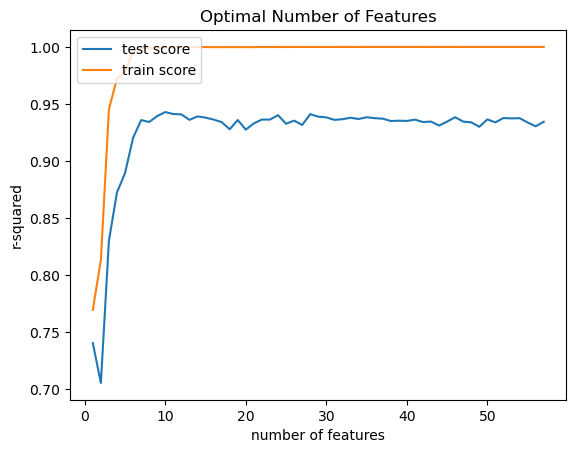

In [10]:
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [11]:
rfe = RFE(xgb, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('K_frac', False, 13),
 ('Rb_frac', False, 14),
 ('Cs_frac', False, 35),
 ('MA_frac', False, 15),
 ('FA_frac', False, 20),
 ('Li_frac', False, 47),
 ('Ca_frac', False, 34),
 ('Sr_frac', False, 25),
 ('Ba_frac', False, 33),
 ('Ge_frac', False, 21),
 ('Sn_frac', True, 1),
 ('Pb_frac', False, 10),
 ('Be_frac', False, 41),
 ('Ni_frac', False, 40),
 ('Cl_frac', False, 7),
 ('Br_frac', False, 27),
 ('I_frac', False, 2),
 ('F_frac', False, 46),
 ('A_Ionic_radius', True, 1),
 ('B_Ionic_radius', False, 16),
 ('X_Ionic_radius', False, 4),
 ('A+B_Ionic_radius', False, 9),
 ('A+X_Ionic_radius', False, 6),
 ('B+X_Ionic_radius', False, 5),
 ('A/B_Ionic_radius', False, 11),
 ('A/X_Ionic_radius', True, 1),
 ('B/X_Ionic_radius', True, 1),
 ('Tolerance factor', False, 8),
 ('Octahedral factor', False, 19),
 ('A_Ionization energy(kJ/mol)', False, 18),
 ('B_Ionization energy(kJ/mol)', True, 1),
 ('X_Ionization energy(kJ/mol)', True, 1),
 ('A_Electron_affinity(kJ/mol)', False, 30),
 ('B_Electron_affinity(